# Proyecto 4: Faces in The Wild

**Integrantes**:
- Lucas Carranza
- David Herencia
- Kalos Lazo
- Lenin Chavez

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda:0


## Exploración del Dataset

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Split the 'image1_image2' column into two columns
train_df[['image1', 'image2']] = train_df['image1_image2'].str.split('_', expand=True)
test_df[['image1', 'image2']] = test_df['image1_image2'].str.split('_', expand=True)

# Drop the original 'image1_image2' column
train_df.drop(columns=['image1_image2'], inplace=True)
test_df.drop(columns=['image1_image2'], inplace=True)

# Reorder cols
train_df = train_df[['image1', 'image2', 'label']]

# Convert label image to number
# diff = 0
# same = 1
train_df['label'] = pd.factorize(train_df['label'])[0]

train_df.head()

,image1,image2,label
0,1485,4047,0
1,5335,6055,1
2,10796,3696,1
3,11991,6672,1
4,7003,2539,1


In [57]:
# Helper functions to load images from dataset and plot them
image_path = "cropped_faces"

def load_img(img_id):
    path = f"{image_path}/{img_id}.png"
    return Image.open(path)

def plot_imgs(imgs, size=3):
    img_number = imgs.shape[0]
    rows = cols = math.ceil(np.sqrt(img_number))
    fig = plt.figure(figsize=(rows*size, cols*size))
    for i in range(img_number):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

def visualize_samples(loader, num_samples=5, size=3):
    rows = cols = math.ceil(np.sqrt(num_samples))
    fig = plt.figure(figsize=(rows*size, cols*size))
    for images1, images2, labels in loader:
        for i in range(num_samples):
            plt.subplot(rows, cols, i+1)
            image = images1[i].permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) to (H, W, C) and convert to numpy array
            plt.imshow(image)
            plt.axis('off')
        break
    plt.show()

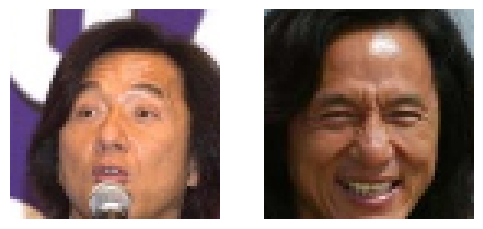

(64, 64, 3)

In [59]:
# Example on how to load and plot images
im1 = load_img(train_df['image1'][1347])
im2 = load_img(train_df['image2'][1347])
plot_imgs(np.array([im1, im2]))

np.array(im1).shape # Imagenes de 64x64 en formato RGB

## Modelo 1: Siamese CNN

### Data Loader for Siamese CNN

Debido a que la Red Neuronal Convolucional requiere de 2 entradas de imagenes para validar si corresponden a la misma persona o no, requerimos de un Dataset personalizado, donde la entrada consista en 2 imagenes y un label. Es por esto que creamos la clase `TwoImageDataset` a partir de la clase `Dataset` de pytorch, la cual puede obtener todos los pares de imágenes y cargarlos de dos en dos junto con el label que nos indican si son la misma persona o no.

In [7]:
class TwoImageDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_id = self.df.iloc[idx, 0]
        img2_id = self.df.iloc[idx, 1]

        img1 = load_img(img1_id).convert('RGB')
        img2 = load_img(img2_id).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if self.is_test:
            return img1, img2
            
        label = self.df.iloc[idx, 2]
        return img1, img2, torch.tensor(label, dtype=torch.float32)

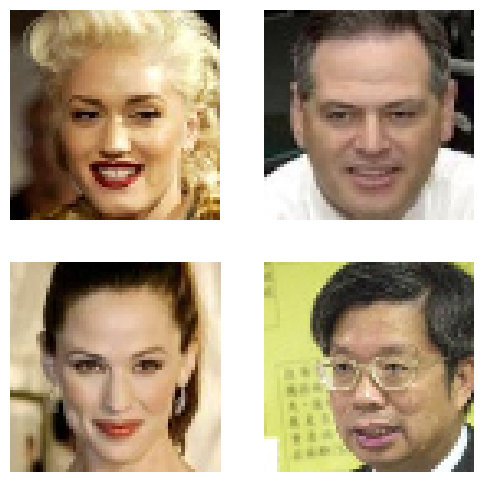

In [69]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with Image stats
])

# Train-Test split
from sklearn.model_selection import train_test_split
train_subset_df, val_subset_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Initializing custom datasets
train_dataset = TwoImageDataset(train_subset_df, transform=transform)
val_dataset = TwoImageDataset(val_subset_df, transform=transform)
test_dataset = TwoImageDataset(test_df, transform=transform, is_test=True)

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example to check the dataloader
visualize_samples(train_dataloader, 4)

In [75]:
class SiameseCNN(nn.Module):
    def __init__(self):
        super(SiameseCNN, self).__init__()

        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=7, padding=3), #100
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=5, padding=2), #100
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=3, padding=1), #100
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #50
            
        #     nn.Conv2d(64, 128, kernel_size=7, padding=3), #50
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, kernel_size=5, padding=2), #50
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, kernel_size=3, padding=1), #50
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #25

        #     nn.Dropout(0.1),
            
        #     nn.Conv2d(128, 256, kernel_size=3, padding=1), #25
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, kernel_size=3, padding=1), #25
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #12

        #     nn.Dropout(0.1),
            
        #     nn.Conv2d(256, 512, kernel_size=3, padding=1), #12
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, padding=1), #12
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #6
            
        #     nn.Dropout(0.1),
        # )

        from torchvision import models
        alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
        self.conv1 = nn.Sequential(*list(alexnet.children())[:-1])

        self.fc = nn.Sequential(
            nn.Linear(256*6*6 * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        # print(out1.shape)
        
        concat = torch.cat((out1, out2), 1)
        # print(concat.shape)
        
        output = self.fc(concat)
        output = torch.flatten(output)
        # print(output)
        return output

    def train_cnn(self, train_loader, loss_fn, optimizer, scheduler=None, num_epochs=5):
        total_step = len(train_loader)
        list_loss = []
        for epoch in range(num_epochs):
            model.train()
            for i, (images1, images2, labels) in enumerate(train_loader):
                images1 = images1.to(device)
                images2 = images2.to(device)
                labels = labels.to(device)
    
                output = self(images1, images2)
                loss = loss_fn(output, labels)
    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                list_loss.append(loss.item())
                i += 1
    
                if (i + 1) % 10 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
                          .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

            if scheduler:
                scheduler.step()
    
        print('Finished Training Trainset')
        return list_loss
    
    def predict(self, dataloader, with_labels=False):
        y_pred = []
        model.eval()
        with torch.no_grad():
            if not with_labels:
                for image1, image2 in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            else:
                for image1, image2, _ in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            return y_pred

In [76]:
learning_rate = 0.0001
model = SiameseCNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=0.1)

In [77]:
torch.cuda.empty_cache()
epochs = 24
list_loss = model.train_cnn(train_dataloader, loss_fn, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch [1/24], Step [10/28], Loss: 0.7366530299186707
Epoch [1/24], Step [20/28], Loss: 0.7217134833335876
Epoch [2/24], Step [10/28], Loss: 0.57318115234375
Epoch [2/24], Step [20/28], Loss: 0.5457135438919067
Epoch [3/24], Step [10/28], Loss: 0.5098859071731567
Epoch [3/24], Step [20/28], Loss: 0.4415571391582489
Epoch [4/24], Step [10/28], Loss: 0.46160808205604553
Epoch [4/24], Step [20/28], Loss: 0.45376917719841003
Epoch [5/24], Step [10/28], Loss: 0.44289538264274597
Epoch [5/24], Step [20/28], Loss: 0.405872106552124
Epoch [6/24], Step [10/28], Loss: 0.4495999813079834
Epoch [6/24], Step [20/28], Loss: 0.4676358699798584
Epoch [7/24], Step [10/28], Loss: 0.45607271790504456
Epoch [7/24], Step [20/28], Loss: 0.46032536029815674
Epoch [8/24], Step [10/28], Loss: 0.434492826461792
Epoch [8/24], Step [20/28], Loss: 0.4779041111469269
Epoch [9/24], Step [10/28], Loss: 0.44761979579925537
Epoch [9/24], Step [20/28], Loss: 0.4200306236743927
Epoch [10/24], Step [10/28], Loss: 0.4115027

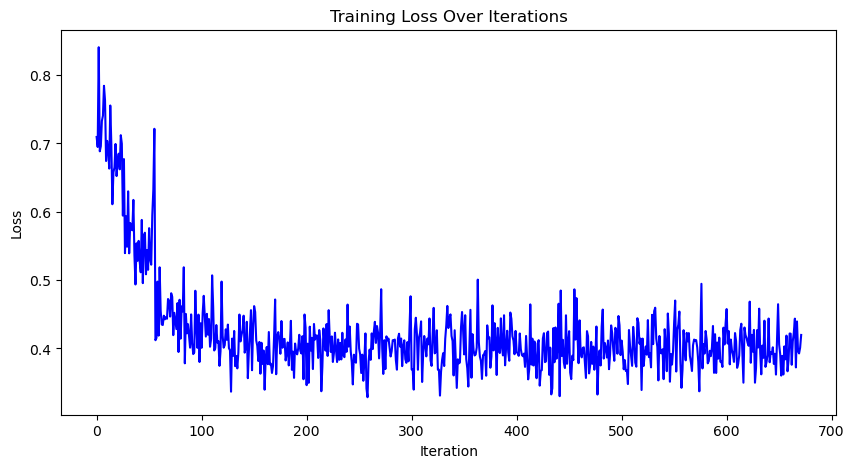

In [73]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       220
           1       0.64      0.70      0.67       220

    accuracy                           0.65       440
   macro avg       0.65      0.65      0.65       440
weighted avg       0.65      0.65      0.65       440



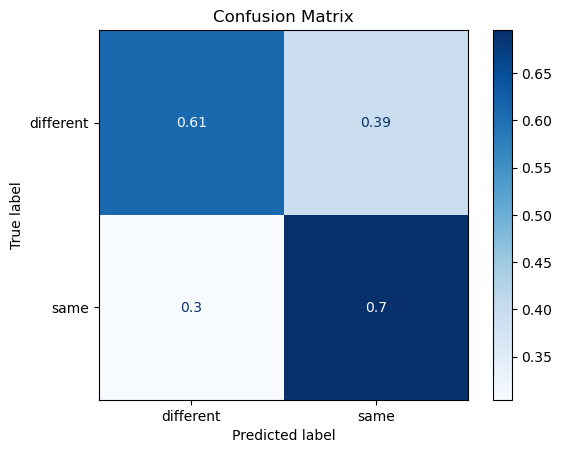

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

val_pred = model.predict(val_dataloader, with_labels=True)
cm = confusion_matrix(val_subset_df['label'], val_pred, normalize='true')

# Generate the classification report
report = classification_report(val_subset_df['label'], val_pred)
print("Classification Report:")
print(report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['different', 'same'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_values = model.predict(test_dataloader)
print(np.unique(test_values))

## Modelo 2: ??

## Experimentación

## Testing